## Capstone 1 
# San Francisco Bay Water Quality

ref. [Water quality of SF Bay home page](https://sfbay.wr.usgs.gov/access/wqdata/index.html)
     


## Unit 8 - Statistics

Based on your dataset, the questions that interest you, and the results of the visualization techniques that you used previously, you should choose the most relevant statistical inference techniques. You aren’t expected to demonstrate all of them. You may find yourself revisiting the analytical framework that you first used to develop your proposal questions. It’s fine to refine your questions more as you get deeper into your data and find interesting patterns and answers. 

Think of the following questions and apply them to your dataset:

   * Are there variables that are particularly significant in terms of explaining the answer to your project question?
   * Are there significant differences between subgroups in your data that may be relevant to your project aim?
   * Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
   * What are the most appropriate tests to use to analyze these relationships?

Ideas:

   1. Hypothesis test: I know that salinity is very low where the Sacramento River meets the Bay and highest at the Golden Gate where the Bay meets the ocean, but how does salinity compare between stations south of the Gate? They're similar; are they the same?<br>
   <i>Hypothesis</i>: Mean salinity does differ between the station groups closest to the Gate, in San Mateo County, and in Sana Clara county (further south).

   2. Covariance and Pearson correlation coefficient: Correlation between nutrients and phytoplankton biovolume

   3. Covariance and Pearson correlation coefficient: Correlation between phytoplankton biovolume and oxygen

## Data 

#### Files
   1. `SFBayWaterQuality.csv` - all water quality parameters
   2. `SFBayWaterQualityNutrientData.csv` - only nutrient data samples
   3. `water_quality_units.json` - units dictionary
   4. `SFBayStationLocations.csv` - sampling location information
   5. `station_stats.json` - by-station statistics
   5. `Phytoplankton.csv` - phytoplankton information


## Sampling stations

[Map](https://batchgeo.com/map/68e8afb69e93ec948b457d57c0589742) of sampling stations. Distance from station 36 has been computed. Additional details can be seen in the [interactive map](https://batchgeo.com/map/68e8afb69e93ec948b457d57c0589742).

![StationMap.png](attachment:StationMap.png)
(built using [BatchGeo](https://batchgeo.com))

## Setup

Import libraries

In [1]:
import json

import numpy as np
import pandas as pd
#import pymc3 as pm
from scipy import stats

import matplotlib.pyplot as plt

## Read in the data

In [2]:
# Read in the Water Quality data
wq_df = pd.read_csv('Data/SFBayWaterQualityPlus.csv', 
                    header=0, 
                    parse_dates=['DateTime', 'Date'],
                    dtype={'Station' : str}
                    )

# The sampling stations, in geographical order 
# from the Sacramento River south to San Jose

with open('Data/station_list.json', 'r') as fp:
    station_list = json.load(fp)

# Stations are actually categories
wq_df['Station'] = pd.Categorical(wq_df['Station'],
                                  categories=station_list
                                 )

# Dictionary of Water Quality parameters and units
with open('Data/water_quality_units.json', 'r') as f:
    wq_units = json.load(f)

wq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237061 entries, 0 to 237060
Data columns (total 23 columns):
Date                                 237061 non-null datetime64[ns]
Station                              237061 non-null category
Depth                                237061 non-null float64
DateTime                             237061 non-null datetime64[ns]
Distance from 36                     236597 non-null float64
Chlorophyll a/a+PHA                  12895 non-null float64
Fluorescence                         220308 non-null float64
Calculated Chlorophyll               225275 non-null float64
Oxygen Electrode Output              189908 non-null float64
Oxygen Saturation %                  191606 non-null float64
Calculated Oxygen                    188107 non-null float64
Calculated SPM                       200937 non-null float64
Measured Extinction Coefficient      13987 non-null float64
Calculated Extinction Coefficient    4772 non-null float64
Salinity                

In [3]:
# Group stations. Based on the map, we'll choose groups of 8.
i = 0
g = 0
group = {}
s = list(reversed(station_list))
while (i <= len(s)):
    group[g] = s[i:i+8]
    g += 1
    i += 8

print(group)

{0: ['36', '35', '34', '33', '32', '31', '30', '29.5'], 1: ['29', '28.5', '28', '27', '26', '25', '24', '23'], 2: ['22', '21', '20', '19', '18', '17', '16', '15'], 3: ['14', '13', '12.5', '12', '11', '10', '9', '8'], 4: ['405', '7', '6', '5', '411', '407', '4', '3'], 5: ['2', '649', '650', '651', '652', '653', '654', '655'], 6: ['657', '659', '662']}


In [4]:
st_group_names = {
    6: 'Upper Sacramento River',
    5: 'Lower Sacramento River',
    4: 'Suisun Bay',
    3: 'San Pablo Bay',
    2: 'Golden Gate',
    1: 'Central Bay (San Mateo County)',
    0: 'South Bay (San Jose)'
}

In [5]:
# Extract DataFrames for each station group
i=0
st_groups = {}
while (i < len(group)):
    st_groups[i] = wq_df[wq_df['Station'].isin(group[i])]
    i += 1
    

In [6]:
st_groups[0]

,Date,Station,Depth,DateTime,Distance from 36,Chlorophyll a/a+PHA,Fluorescence,Calculated Chlorophyll,Oxygen Electrode Output,Oxygen Saturation %,...,Calculated Extinction Coefficient,Salinity,Temperature,Sigma-t,Nitrite,Nitrate + Nitrite,Ammonium,Phosphate,Silicate,Biovolume
106,1969-04-11,30,0.5,1969-04-11 17:35:00,14.75,NaN,NaN,NaN,NaN,NaN,...,NaN,17.60,14.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,1969-04-11,30,2.0,1969-04-11 17:37:00,14.75,NaN,NaN,NaN,NaN,NaN,...,NaN,17.70,14.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,1969-04-11,30,4.0,1969-04-11 17:39:00,14.75,NaN,NaN,NaN,NaN,NaN,...,NaN,17.70,14.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,1969-04-11,30,6.0,1969-04-11 17:41:00,14.75,NaN,NaN,NaN,NaN,NaN,...,NaN,17.70,14.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,1969-04-11,30,11.0,1969-04-11 17:43:00,14.75,NaN,NaN,NaN,NaN,NaN,...,NaN,17.60,14.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,1969-04-11,31,0.5,1969-04-11 17:50:00,10.61,NaN,NaN,NaN,NaN,NaN,...,NaN,16.90,14.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112,1969-04-11,31,2.0,1969-04-11 17:52:00,10.61,NaN,NaN,NaN,NaN,NaN,...,NaN,17.00,14.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,1969-04-11,31,4.0,1969-04-11 17:54:00,10.61,NaN,NaN,NaN,NaN,NaN,...,NaN,17.00,14.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,1969-04-11,31,6.0,1969-04-11 17:56:00,10.61,NaN,NaN,NaN,NaN,NaN,...,NaN,17.00,14.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,1969-04-11,31,11.0,1969-04-11 17:58:00,10.61,NaN,NaN,NaN,NaN,NaN,...,NaN,16.90,14.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# extract DataFrames by month for station groups 
# 0 (San Jose), 1 (San Mateo), 2 (GG), 3 (San Pablo Bay), 4 (Suisun Bay)
group0_month = {}
group1_month = {}
group2_month = {}
group3_month = {}
group4_month = {}

for m in range(1,13):
    mask = (wq_df['DateTime'].dt.month == m)

    group0_month[m] = st_groups[0].loc[mask]
    group1_month[m] = st_groups[1].loc[mask]
    group2_month[m] = st_groups[2].loc[mask]
    group3_month[m] = st_groups[3].loc[mask]
    group4_month[m] = st_groups[4].loc[mask]
#end_for  



In [8]:
def summary_stats(s, col):
    """ 
    Calculate and return a dictionary of summary statistics.
    
    Parameters:
      s: Series or list
      col = string; the name of the column we're calculating over

    Returns: a dictionary of statistics for the series 
    """
    
    stats = {
      'parameter': col,
      'count': 0,
      'max': 0,
      'min': 0,
      'mean': 0,
      'median': 0,
      'mode': 0,
      'std': 0,
    }
    
    stats['count'] = s.count()
    stats['max'] = s.max()
    stats['min'] = s.min()
    stats['mean'] = round(s.mean(),3)
    stats['median'] = s.median()
    stats['mode'] = s.mode()[0]
    stats['std'] = round(s.std(),3)

            
    return(stats)
    
#end_def summary_stats

In [9]:
# calculate Salinity stats by month for station groups 

group0_stats = {}
group1_stats = {}
group2_stats = {}
group3_stats = {}
group4_stats = {}

for m in range(1,13):
    mask = (wq_df['DateTime'].dt.month == m)

    group0_stats[m] = summary_stats(group0_month[m]['Salinity'], 'Salinity')
    group1_stats[m] = summary_stats(group1_month[m]['Salinity'], 'Salinity')
    group2_stats[m] = summary_stats(group2_month[m]['Salinity'], 'Salinity')
    group3_stats[m] = summary_stats(group3_month[m]['Salinity'], 'Salinity')
    group4_stats[m] = summary_stats(group4_month[m]['Salinity'], 'Salinity')

#end_for

# group2_stats[6]['median']

In [10]:
group0_sal_df = pd.DataFrame.from_dict(group0_stats, orient='index')
group1_sal_df = pd.DataFrame.from_dict(group1_stats, orient='index')
group2_sal_df = pd.DataFrame.from_dict(group2_stats, orient='index')
group3_sal_df = pd.DataFrame.from_dict(group3_stats, orient='index')
group4_sal_df = pd.DataFrame.from_dict(group4_stats, orient='index')

group4_sal_df

,parameter,count,max,min,mean,median,mode,std
1,Salinity,1649,20.89,0.03,5.086,3.040,0.06,5.444
2,Salinity,1900,17.12,0.06,3.177,0.470,0.09,4.322
3,Salinity,1827,18.24,0.00,2.182,0.200,0.07,3.672
4,Salinity,1948,17.30,0.00,1.979,0.270,0.07,3.112
5,Salinity,1825,19.00,0.00,3.674,1.790,0.08,4.265
6,Salinity,1734,18.45,0.00,3.759,2.185,0.07,4.243
7,Salinity,1812,20.10,0.06,6.264,5.200,0.06,4.727
8,Salinity,1894,19.30,0.09,6.309,5.400,0.81,4.646
9,Salinity,1991,22.20,0.09,8.015,7.250,0.34,4.990
10,Salinity,1772,21.94,0.16,9.636,9.325,0.80,4.998


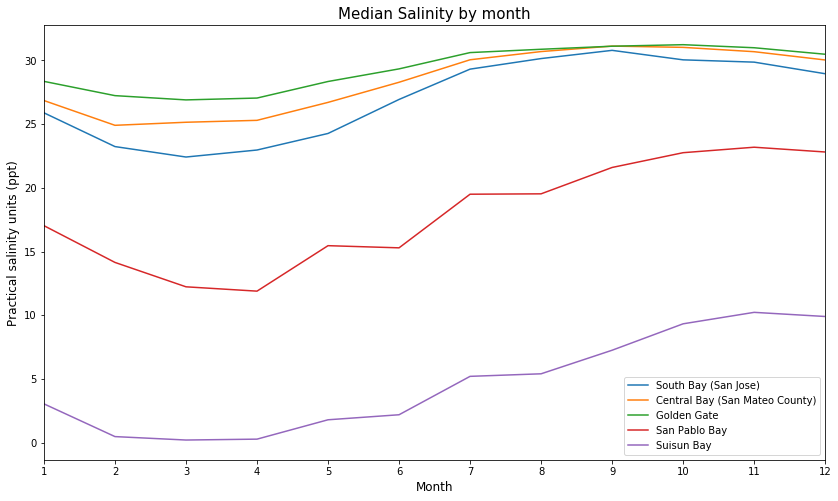

In [11]:
fig, ax = plt.subplots(figsize=(14,8))
group0_sal_df.plot(y='median', label=st_group_names[0], ax=ax)
group1_sal_df.plot(y='median', label=st_group_names[1], ax=ax)
group2_sal_df.plot(y='median', label=st_group_names[2], ax=ax)
group3_sal_df.plot(y='median', label=st_group_names[3], ax=ax)
group4_sal_df.plot(y='median', label=st_group_names[4], ax=ax)
plt.xticks(np.arange(1,13))
plt.xlabel("Month", fontsize=12)
plt.ylabel("Practical salinity units (ppt)", fontsize=12)
plt.title("Median Salinity by month", fontsize=15)

plt.show()

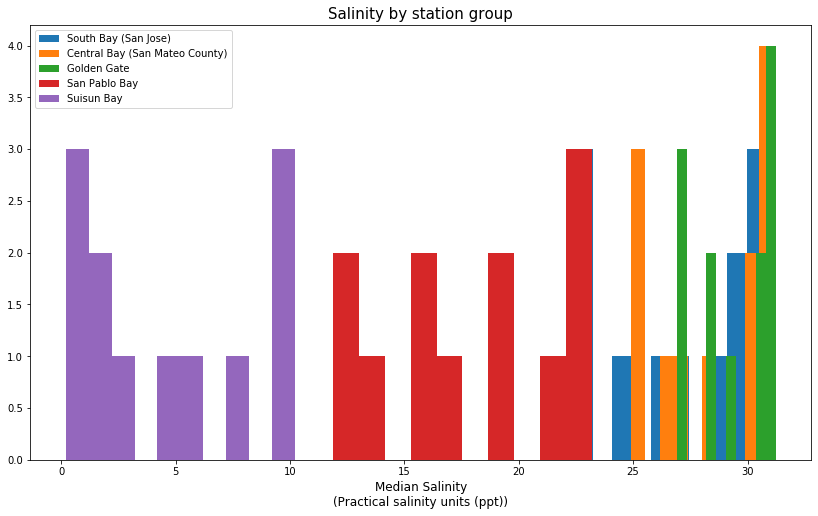

In [12]:
fig, ax0 = plt.subplots(figsize=(14,8))
_ = plt.hist(group0_sal_df['median'], label=st_group_names[0])
_ = plt.hist(group1_sal_df['median'], label=st_group_names[1])
_ = plt.hist(group2_sal_df['median'], label=st_group_names[2])
_ = plt.hist(group3_sal_df['median'], label=st_group_names[3])
_ = plt.hist(group4_sal_df['median'], label=st_group_names[4])
_ = plt.xlabel("Median Salinity\n(Practical salinity units (ppt))",fontsize=12)
_ = plt.title("Salinity by station group", fontsize=15)

plt.legend(prop={'size': 10})

plt.show()

**Note** The stacked bar chart below is not "proportional". The bars are overlaid; they don't "add up".

I realize that this is not the common way to "stack" histograms, but it does provide a handy view of the data.

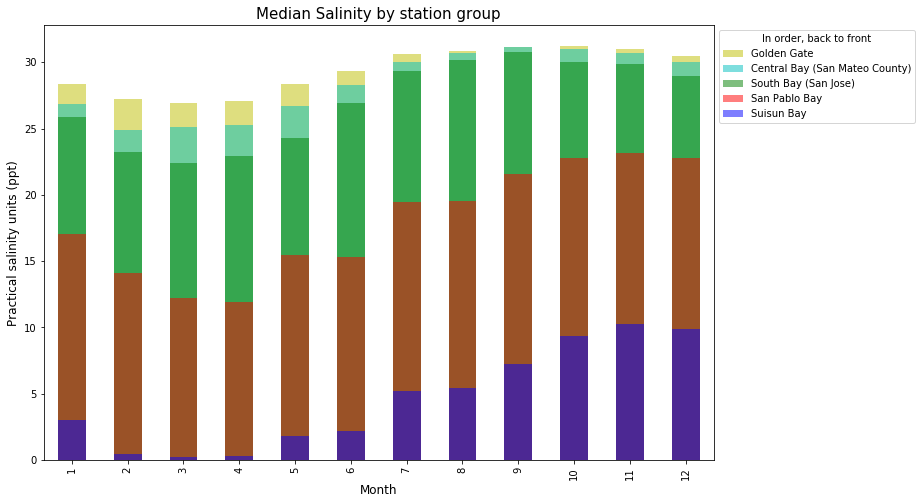

In [13]:
fig, ax0 = plt.subplots(figsize=(12,8))
kwargs = dict(alpha=0.5, ax=ax0)
_ = group2_sal_df.plot.bar(y='median', label=st_group_names[2], color='y', **kwargs)
_ = group1_sal_df.plot.bar(y='median', label=st_group_names[1], color='c', **kwargs)
_ = group0_sal_df.plot.bar(y='median', label=st_group_names[0], color='g', **kwargs)
_ = group3_sal_df.plot.bar(y='median', label=st_group_names[3], color='r', **kwargs)
_ = group4_sal_df.plot.bar(y='median', label=st_group_names[4], color='b', **kwargs)

_ = plt.ylabel("Practical salinity units (ppt)", fontsize=12)
_ = plt.xlabel("Month",fontsize=12)

_ = plt.title("Median Salinity by station group", fontsize=15)


plt.legend(bbox_to_anchor=(1.0,1.0), title="In order, back to front")
plt.show()

Here's the same data with the bars next to each other.

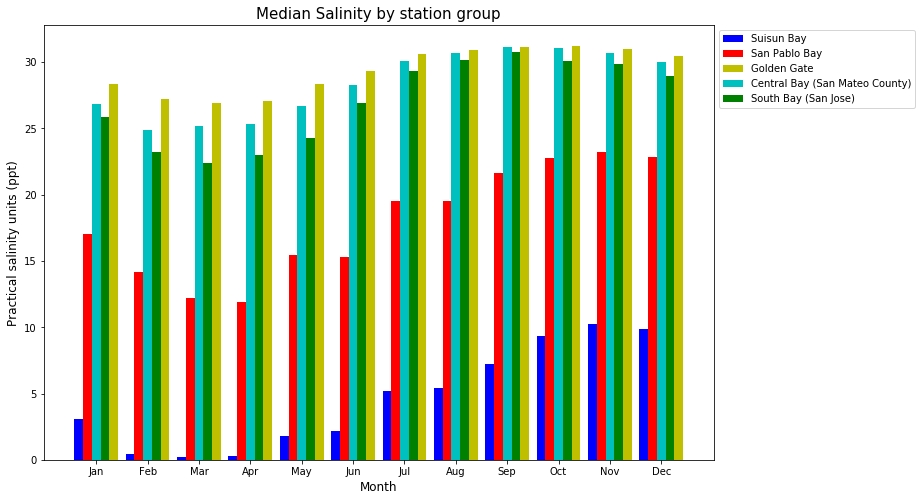

In [14]:
# set width of bar
barwidth = 0.17

 
# Set position of bars on x axis
r0 = np.arange(1, 13)
r1 = [x + barwidth for x in r0]
r2 = [x + barwidth for x in r1]
r3 = [x + barwidth for x in r2]
r4 = [x + barwidth for x in r3] 

fig, ax0 = plt.subplots(figsize=(12,8))
kwargs = dict(width=barwidth)
_ = plt.bar(r0, group4_sal_df['median'], label=st_group_names[4], color='b', **kwargs)
_ = plt.bar(r1, group3_sal_df['median'], label=st_group_names[3], color='r', **kwargs)
_ = plt.bar(r4, group2_sal_df['median'], label=st_group_names[2], color='y', **kwargs)
_ = plt.bar(r2, group1_sal_df['median'], label=st_group_names[1], color='c', **kwargs)
_ = plt.bar(r3, group0_sal_df['median'], label=st_group_names[0], color='g', **kwargs)

_ = plt.ylabel("Practical salinity units (ppt)", fontsize=12)
_ = plt.xlabel("Month", fontsize=12)
_ = plt.xticks([r + 2*barwidth for r in range(1, 13)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

_ = plt.title("Median Salinity by station group", fontsize=15)


plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

Zip the desired columns together so I can just plot a DataFrame without worrying about bar width and shifting over.

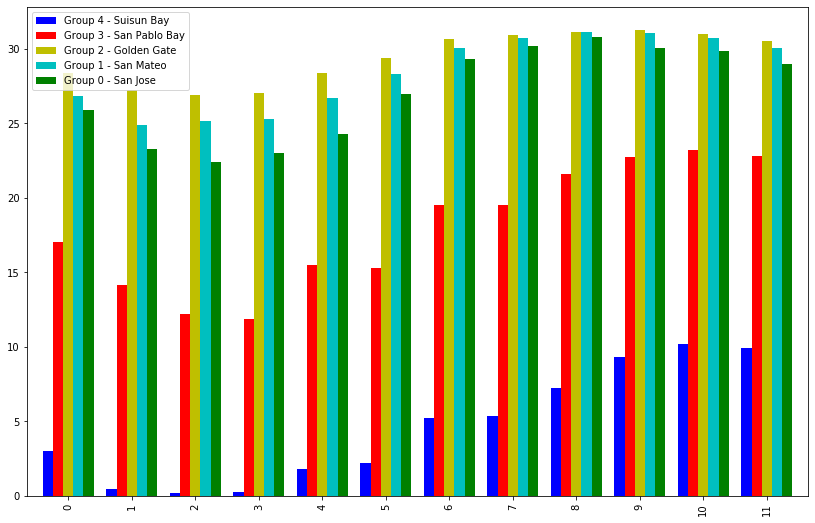

In [15]:
color_list = ['b', 'r', 'y', 'c', 'g']
                        
df = pd.DataFrame(zip(group4_sal_df['median'], group3_sal_df['median'], group2_sal_df['median'], 
                      group1_sal_df['median'], group0_sal_df['median']), 
                  columns=['Group 4 - Suisun Bay', 'Group 3 - San Pablo Bay', 'Group 2 - Golden Gate', 
                           'Group 1 - San Mateo', 'Group 0 - San Jose']
                 )
df.plot.bar(figsize=(14, 9), width=0.8, color=color_list)
plt.legend(prop={'size': 10})
plt.show()

Plot salinity, not median salinity. We get more values this way.

/Local/Users/vlb/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Local/Users/vlb/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


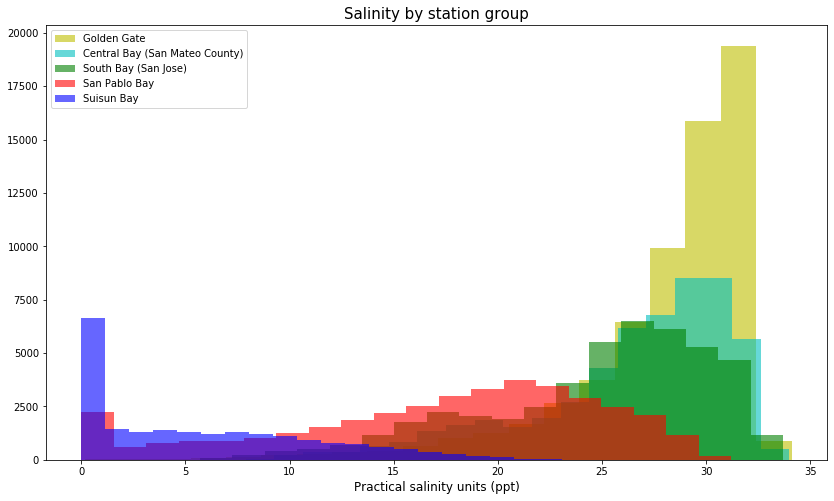

In [16]:
fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20, alpha=0.6,)
_ = plt.hist(st_groups[2]['Salinity'], label=st_group_names[2], color='y', **kwargs)
_ = plt.hist(st_groups[1]['Salinity'], label=st_group_names[1], color='c', **kwargs)
_ = plt.hist(st_groups[0]['Salinity'], label=st_group_names[0], color='g', **kwargs)
_ = plt.hist(st_groups[3]['Salinity'], label=st_group_names[3], color='r', **kwargs)
_ = plt.hist(st_groups[4]['Salinity'], label=st_group_names[4], color='b', **kwargs)

_ = plt.xlabel("Practical salinity units (ppt)", fontsize=12)
_ = plt.title("Salinity by station group", fontsize=15)

plt.legend(prop={'size': 10})

plt.show()


Stations north of the gate are much lower than I thought.

Let's just look at the Central Bay and South Bay.

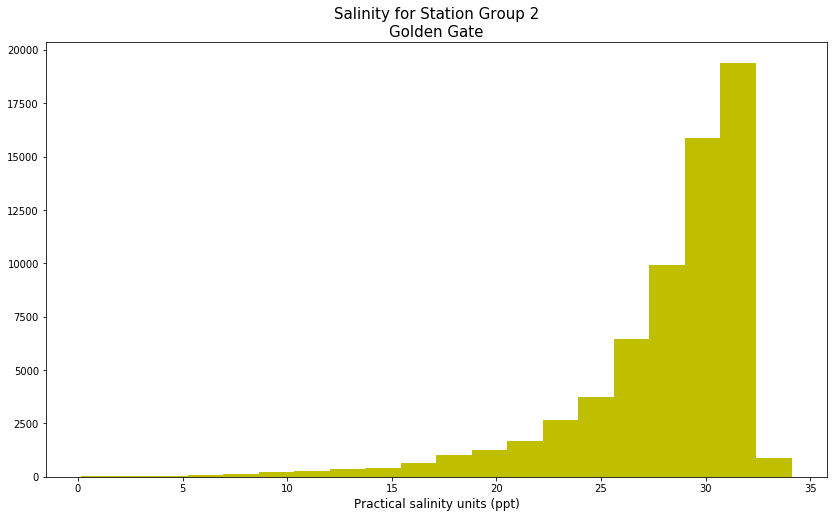

In [17]:
title = "Salinity for Station Group 2\n" + st_group_names[2]

fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20)
_ = plt.hist(st_groups[2]['Salinity'], color='y', **kwargs)

_ = plt.xlabel("Practical salinity units (ppt)", fontsize=12)
_ = plt.title(title, fontsize=15)


plt.show()


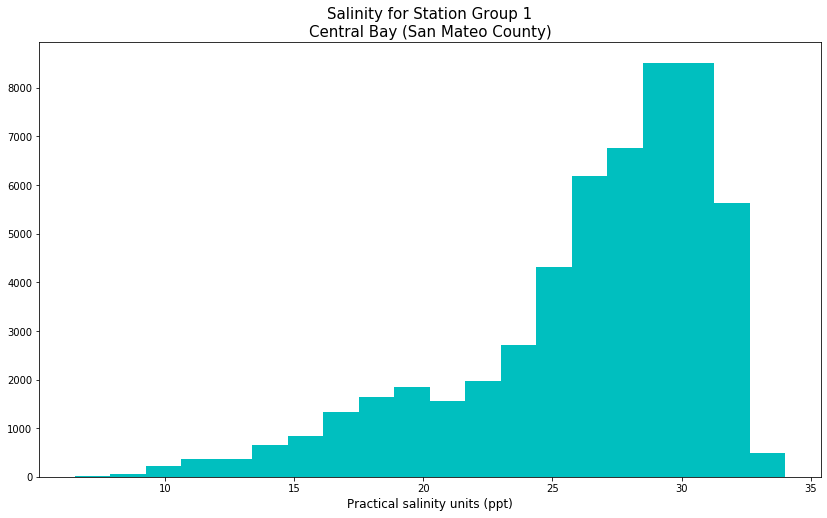

In [18]:
title = "Salinity for Station Group 1\n" + st_group_names[1]

fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20)
_ = plt.hist(st_groups[1]['Salinity'], color='c', **kwargs)

_ = plt.xlabel("Practical salinity units (ppt)", fontsize=12)
_ = plt.title(title, fontsize=15)


plt.show()


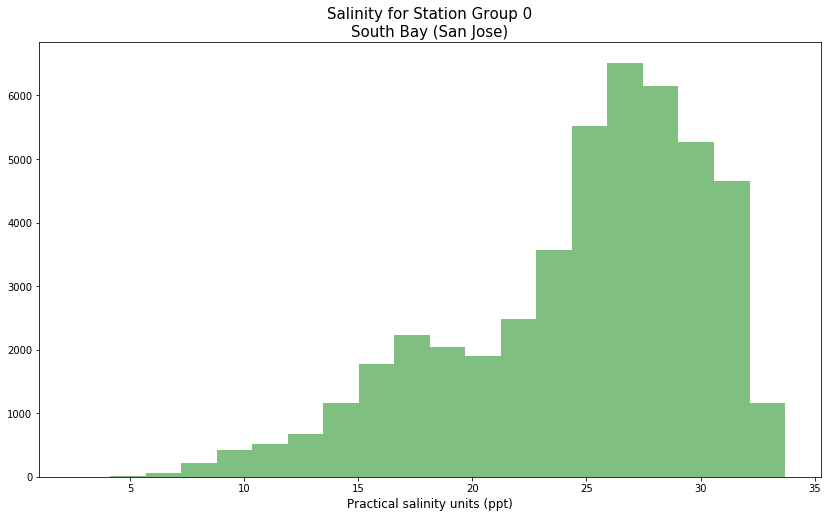

In [19]:
title = "Salinity for Station Group 0\n" + st_group_names[0]

fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20)
_ = plt.hist(st_groups[0]['Salinity'], color='g', alpha=0.5, **kwargs)

_ = plt.xlabel("Practical salinity units (ppt)", fontsize=12)
_ = plt.title(title, fontsize=15)


plt.show()


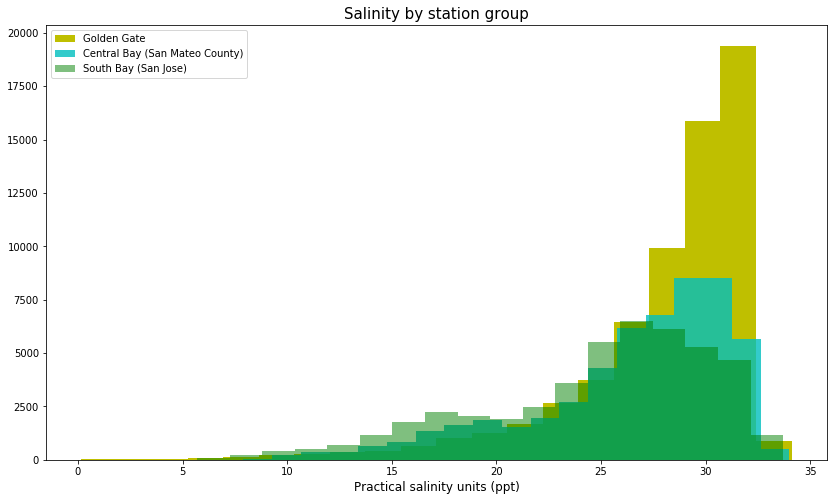

In [20]:
fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20)
_ = plt.hist(st_groups[2]['Salinity'], label=st_group_names[2], color='y', **kwargs)
_ = plt.hist(st_groups[1]['Salinity'], label=st_group_names[1], color='c', alpha=0.8, **kwargs)
_ = plt.hist(st_groups[0]['Salinity'], label=st_group_names[0], color='g', alpha=0.5, **kwargs)

_ = plt.xlabel("Practical salinity units (ppt)",fontsize=12)
_ = plt.title('Salinity by station group',fontsize=15)

plt.legend(prop={'size': 10})

plt.show()


What is the mean salinity for each group of stations in this part of the Bay?

In [21]:
mean_0 = st_groups[0]['Salinity'].dropna().mean()
mean_1 = st_groups[1]['Salinity'].dropna().mean()
mean_2 = st_groups[2]['Salinity'].dropna().mean()

print("mean for group 0:", mean_0)
print("mean for group 1:", mean_1)
print("mean for group 2:", mean_2)

mean for group 0: 24.784078166476142
mean for group 1: 26.455936753624457
mean for group 2: 28.05572708826517


The means are close. Is the closeness statistically significant?

_The t test (also called Student’s T Test) compares two averages (means) and tells you if they are different from each other. The t test also tells you how significant the differences are; in other words, it lets you know if those differences could have happened by chance._ ([ref](https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f))

[T-test example reference](https://pythonfordatascience.org/independent-t-test-python/)

If p-value is less than the predetermined value of significance, reject the null hypothesis and accept the alternative hypothesis.

Null hypothesis: There is no difference in the mean salinity between:
   * station groups 1 and 2
   * station groups 0 and 1
   
Alternative Hypothesis: There is a significant difference in the mean salinity between:
   * station groups 1 and 2
   * station groups 0 and 1

**1. Check for Normality & Variance criteria**
<blockquote>
The first step is to check the normality and variance criteria.

### **Normality**

To test for normality, apply the Shapiro-Wilk test by calling the `scipy stats.shapiro()` method.
This control tests the null hypothesis that the data was drawn from a normal distribution and returns the test statistic ('W') and the probability ('p').
The normality criterion holds true when p > alpha (where alpha is the probability threshold, usually set to 0.05).

Important: be sure to call the `dropna()` method on the data set to drop NaN values during testing.<br>

[ref: PytoLearn](http://pytolearn.csd.auth.gr/d1-hyptest/12/ttest-indep.html)
</blockquote>

### **Normal distribution of residuals**

<blockquote>
    
Checking for normality can be done visually or with a formula test. Visually, one can use a p-p plot, a q-q plot, or histogram, and/or one can use the Shapiro-Wilk test to formally test for normality. To test for normality formally, use `stats.shapiro()` which is from the `scipy.stats` library.<br>

[ref: Python for Data Science](https://pythonfordatascience.org/independent-t-test-python/)
</blockquote>


In [22]:
# Shapiro-Wilk normality test for group 0
sw_0 = stats.shapiro(st_groups[0]['Salinity'].dropna())

# Shapiro-Wilk normality test for group 1
sw_1 = stats.shapiro(st_groups[1]['Salinity'].dropna())

# Shapiro-Wilk normality test for group 2
sw_2 = stats.shapiro(st_groups[2]['Salinity'].dropna())

print("Shapiro-Wilk result for station group 0,", st_group_names[0], "\n", sw_0)
print("Shapiro-Wilk result for station group 1,", st_group_names[1], "\n", sw_1)
print("Shapiro-Wilk result for station group 2,", st_group_names[2], "\n", sw_2)

Shapiro-Wilk result for station group 0, South Bay (San Jose) 
 (0.9334824085235596, 0.0)
Shapiro-Wilk result for station group 1, Central Bay (San Mateo County) 
 (0.8940597772598267, 0.0)
Shapiro-Wilk result for station group 2, Golden Gate 
 (0.7928236722946167, 0.0)


/Local/Users/vlb/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The distributions are not normal, but "p-value may not be accurate for N > 5000".

We can also check for normality a different way, using a probability plot.

```
scipy.stats.probplot
Calculate quantiles for a probability plot, and optionally show the plot.
```

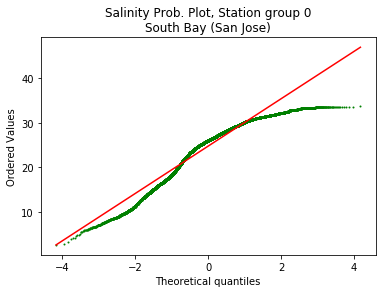

In [23]:
fig, ax = plt.subplots()
stats.probplot(st_groups[0]['Salinity'].dropna(), plot=plt)
plt.title("Salinity Prob. Plot, Station group 0\n" + st_group_names[0]) 
ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_markersize('2')

plt.show()

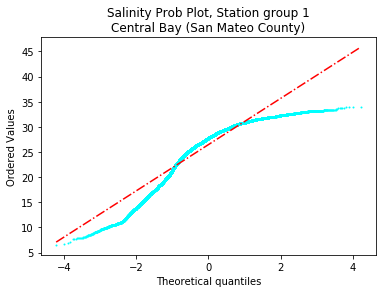

In [24]:
fig, ax = plt.subplots()
stats.probplot(st_groups[1]['Salinity'].dropna(), plot=plt)

ax.get_lines()[0].set_markerfacecolor('cyan')
ax.get_lines()[0].set_markeredgecolor('cyan')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_markersize('2')

ax.get_lines()[1].set_linestyle('-.')
plt.title("Salinity Prob Plot, Station group 1\n" + st_group_names[1]) 

plt.show()

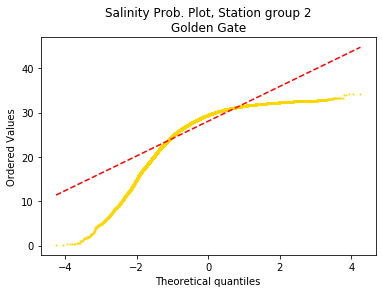

In [25]:
fig, ax = plt.subplots()
stats.probplot(st_groups[2]['Salinity'].dropna(), plot=ax)
ax.get_lines()[0].set_markerfacecolor('gold')
ax.get_lines()[0].set_markeredgecolor('gold')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_markersize('2')

ax.get_lines()[1].set_linestyle('--')
plt.title("Salinity Prob. Plot, Station group 2\n" + st_group_names[2]) 
plt.show()

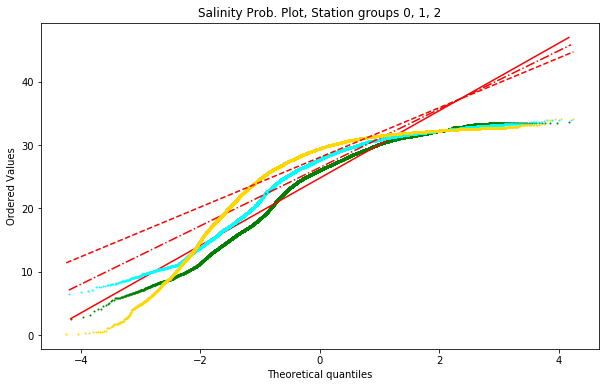

In [26]:
# Plot all thre groups on the same chart

fig, ax = plt.subplots(figsize=(10,6))
stats.probplot(st_groups[0]['Salinity'].dropna(), plot=ax)
stats.probplot(st_groups[1]['Salinity'].dropna(), plot=ax)
stats.probplot(st_groups[2]['Salinity'].dropna(), plot=ax)


ax.get_lines()[0].set_markerfacecolor('green')
ax.get_lines()[0].set_markeredgecolor('green')
ax.get_lines()[0].set_marker('.')
ax.get_lines()[0].set_markersize('2')

ax.get_lines()[1].set_linestyle('-')

ax.get_lines()[2].set_markerfacecolor('cyan')
ax.get_lines()[2].set_markeredgecolor('cyan')
ax.get_lines()[2].set_marker('.')
ax.get_lines()[2].set_markersize('2')

ax.get_lines()[3].set_linestyle('-.')

ax.get_lines()[4].set_markerfacecolor('gold')
ax.get_lines()[4].set_markeredgecolor('gold')
ax.get_lines()[4].set_marker('.')
ax.get_lines()[4].set_markersize('2')

ax.get_lines()[5].set_linestyle('--')

plt.title('Salinity Prob. Plot, Station groups 0, 1, 2') 
plt.show()

Yep. Not normal. We didn't think they were. They all have a tail off to the left.

Let's keep going and see where we end up.

**Variance**

<blockquote>
    
To test for variance, apply the Levene test by calling the scipy `stats.levene()` method
This control tests tests the null hypothesis that all samples come from populations with equal variances. It returns the test statistic ('W') and the probability ('p').
The variance criterion holds true when p > alpha (where alpha is the probability threshold usually set to 0.05)

[ref: PytoLearn](http://pytolearn.csd.auth.gr/d1-hyptest/12/ttest-indep.html)

</blockquote>

Note:
<blockquote>
Three variations of Levene’s test are possible. The possibilities and their recommended usages are:

   * ‘mean’ -
   Recommended for symmetric, moderate-tailed distributions

   * ‘median’ -
   Recommended for skewed (non-normal) distributions

   * ‘trimmed’ -
   Recommended for heavy-tailed distributions
   
   [ref: scipy docs](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html)
</blockquote>
The default is ‘median’. 

We don't have normal distributions, so we'll try both `median` and `trimmed`.



In [27]:
lev_2_1_m = stats.levene(st_groups[2]['Salinity'].dropna(), st_groups[1]['Salinity'].dropna(), center='median')
lev_2_1_t = stats.levene(st_groups[2]['Salinity'].dropna(), st_groups[1]['Salinity'].dropna(), center='trimmed')

lev_1_0_m = stats.levene(st_groups[1]['Salinity'].dropna(), st_groups[0]['Salinity'].dropna(), center='median')
lev_1_0_t = stats.levene(st_groups[1]['Salinity'].dropna(), st_groups[0]['Salinity'].dropna(), center='trimmed')

print("Levene result for station group 2,", st_group_names[2], 
      "\n\tvs group 1,", st_group_names[1])
print("median:\n", lev_2_1_m, "\ntrimmed\n", lev_2_1_t)
print("")
print("Levene result for station group 1,", st_group_names[1], 
      "\n\tvs group 0,", st_group_names[0])
print("median:\n", lev_1_0_m, "\ntrimmed\n", lev_1_0_t)


Levene result for station group 2, Golden Gate 
	vs group 1, Central Bay (San Mateo County)
median:
 LeveneResult(statistic=1233.9270599281986, pvalue=6.212186164025708e-269) 
trimmed
 LeveneResult(statistic=3531.3928196383067, pvalue=0.0)

Levene result for station group 1, Central Bay (San Mateo County) 
	vs group 0, South Bay (San Jose)
median:
 LeveneResult(statistic=737.9652460182751, pvalue=6.429550916590033e-162) 
trimmed
 LeveneResult(statistic=1199.1171405669688, pvalue=4.93712551633467e-261)


p << 0.05

The variances are not homogeneous.

We'll need to pass `equal_var=False` to `stats.ttest_ind`

In [28]:
t_2_1, p_2_1 = stats.ttest_ind(st_groups[2]['Salinity'].dropna(), st_groups[1]['Salinity'].dropna(), equal_var=False)

t_1_0, p_1_0 = stats.ttest_ind(st_groups[1]['Salinity'].dropna(), st_groups[0]['Salinity'].dropna(), equal_var=False)

print("Welch's t-test result for station group 2, ", st_group_names[2], 
      "\n\tvs group 1,", st_group_names[1])
print(t_2_1, "\np:", p_2_1)
print("")
print("Welch's t-test result for station group 1, ", st_group_names[1], 
      "\n\tvs group 0,", st_group_names[0])
print(t_1_0, "\np:", p_1_0)


Welch's t-test result for station group 2,  Golden Gate 
	vs group 1, Central Bay (San Mateo County)
58.941584001098654 
p: 0.0

Welch's t-test result for station group 1,  Central Bay (San Mateo County) 
	vs group 0, South Bay (San Jose)
50.57729469105698 
p: 0.0


Interpretation of the outcome

Since p < alpha (0.05) in both cases, we can say that the null hypothesis is rejected and suggest that there is a difference in the mean salinity between these groups of stations.

<hr style="border: 3px solid green;">

### Temperature Testing

_Null Hypothesis:_ Mean temperature is essentially the same throughout the Bay.

_Alternative Hypothesis:_ Mean temperature differs between station groups.



Calculate the mean temperature for each station group.

In [19]:
means = {}
for i in range(5):
    means[i] = st_groups[i]['Temperature'].dropna().mean()
    print("the mean salinity for group", i, "is",  means[i])


the mean salinity for group 0 is 16.355256894679698
the mean salinity for group 1 is 15.671708822980788
the mean salinity for group 2 is 14.361755786359295
the mean salinity for group 3 is 15.673822936044228
the mean salinity for group 4 is 16.199174563359346


They look similar.

Now plot temperature for each group.

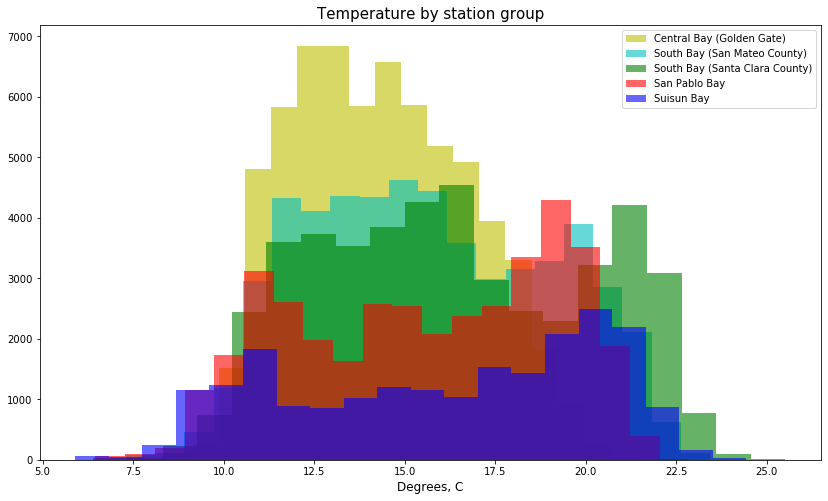

In [20]:
fig, ax0 = plt.subplots(figsize=(14,8))
kwargs = dict(bins=20, alpha=0.6,)
_ = plt.hist(st_groups[2]['Temperature'].dropna(), label=st_group_names[2], color='y', **kwargs)
_ = plt.hist(st_groups[1]['Temperature'].dropna(), label=st_group_names[1], color='c', **kwargs)
_ = plt.hist(st_groups[0]['Temperature'].dropna(), label=st_group_names[0], color='g', **kwargs)
_ = plt.hist(st_groups[3]['Temperature'].dropna(), label=st_group_names[3], color='r', **kwargs)
_ = plt.hist(st_groups[4]['Temperature'].dropna(), label=st_group_names[4], color='b', **kwargs)

_ = plt.xlabel("Degrees, C", fontsize=12)
_ = plt.title("Temperature by station group", fontsize=15)

plt.legend(prop={'size': 10})

plt.show()

They overlap. The means could be the same.

Use OneWay ANOVA – Similar to a ttest, except that this test can be used to compare the means from THREE OR MORE groups.

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

   * The samples are independent.

   * Each sample is from a normally distributed population.

   * The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
   
If these assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis H-test (`scipy.stats.kruskal`) although with some loss of power.

Are the samples normally distributed?

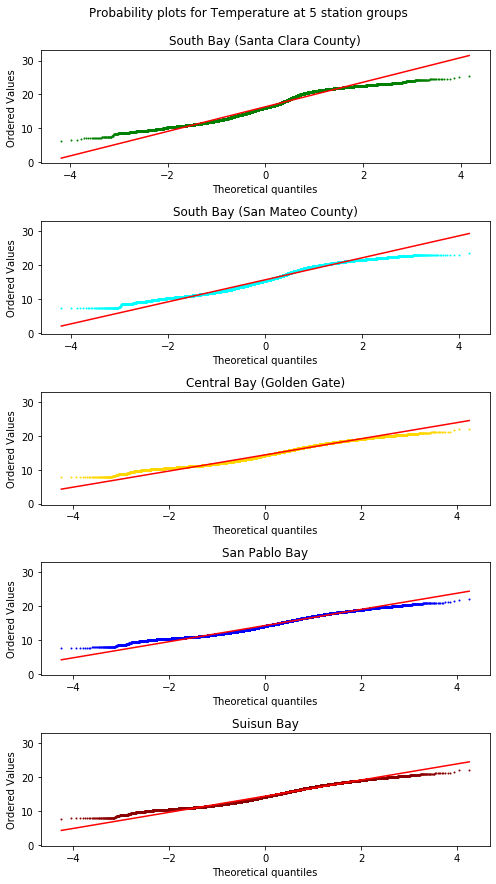

In [21]:
# Probability plots for five station groups

fig, (ax0, ax1, ax2, ax3, ax4)  = plt.subplots(5, sharey=True, figsize=(7, 10))
fig.suptitle("Probability plots for Temperature at 5 station groups", y=1.02)
fig.set_figheight(12)

stats.probplot(st_groups[0]['Temperature'].dropna(), plot=ax0)
stats.probplot(st_groups[1]['Temperature'].dropna(), plot=ax1)
stats.probplot(st_groups[2]['Temperature'].dropna(), plot=ax2)
stats.probplot(st_groups[2]['Temperature'].dropna(), plot=ax3)
stats.probplot(st_groups[2]['Temperature'].dropna(), plot=ax4)

ax0.set_title(st_group_names[0])
ax0.get_lines()[0].set_markerfacecolor('green')
ax0.get_lines()[0].set_markeredgecolor('green')
ax0.get_lines()[0].set_marker('.')
ax0.get_lines()[0].set_markersize('2')

ax1.set_title(st_group_names[1])
ax1.get_lines()[0].set_markerfacecolor('cyan')
ax1.get_lines()[0].set_markeredgecolor('cyan')
ax1.get_lines()[0].set_marker('.')
ax1.get_lines()[0].set_markersize('2')

ax2.set_title(st_group_names[2])
ax2.get_lines()[0].set_markerfacecolor('gold')
ax2.get_lines()[0].set_markeredgecolor('gold')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markersize('2')

ax3.set_title(st_group_names[3])
ax3.get_lines()[0].set_markerfacecolor('blue')
ax3.get_lines()[0].set_markeredgecolor('blue')
ax3.get_lines()[0].set_marker('.')
ax3.get_lines()[0].set_markersize('2')

ax4.set_title(st_group_names[4])
ax4.get_lines()[0].set_markerfacecolor('DARKRED')
ax4.get_lines()[0].set_markeredgecolor('DARKRED')
ax4.get_lines()[0].set_marker('.')
ax4.get_lines()[0].set_markersize('2')


plt.tight_layout()

plt.show()

Are the standard deviations of the groups equal?

In [22]:
print("Temperature:")
std_devs = {}
for i in range(5):
    std_devs[i] = st_groups[i]['Temperature'].dropna().std()
    print("the std deviation for group", i, "is",  std_devs[i])


Temperature:
the std deviation for group 0 is 3.688712735672181
the std deviation for group 1 is 3.2864580083495354
the std deviation for group 2 is 2.402515344395306
the std deviation for group 3 is 3.5440968368424817
the std deviation for group 4 is 4.187827429034062


if group sizes are equal, the F-statistic is robust to violation of the equal standard deviations requirement

In [23]:
print("Temperature:")
counts = {}
for i in range(5):
    counts[i] = st_groups[i]['Temperature'].dropna().count()
    print("the number of samples for group", i, "is",  counts[i])


Temperature:
the number of samples for group 0 is 46050
the number of samples for group 1 is 53610
the number of samples for group 2 is 64894
the number of samples for group 3 is 38167
the number of samples for group 4 is 21528


Try the Kruskal-Wallis H-test

In [24]:
means = {}
for i in range(5):
    means[i] = st_groups[i]['Temperature'].dropna().mean()
    print("the mean salinity for group", i, "is",  means[i])


the mean salinity for group 0 is 16.355256894679698
the mean salinity for group 1 is 15.671708822980788
the mean salinity for group 2 is 14.361755786359295
the mean salinity for group 3 is 15.673822936044228
the mean salinity for group 4 is 16.199174563359346


In [25]:
# Kruskal-Wallis H-test for temperatur difference among 5 station groups
print("Kruskal-Wallis H-test result for station groups 0-4, ")
stats.kruskal(st_groups[0]['Temperature'].dropna(), 
              st_groups[1]['Temperature'].dropna(),
              st_groups[2]['Temperature'].dropna(),
              st_groups[3]['Temperature'].dropna(),
              st_groups[4]['Temperature'].dropna()
             )

Kruskal-Wallis H-test result for station groups 0-4, 


KruskalResult(statistic=10368.357869745143, pvalue=0.0)

In [26]:
# Kruskal-Wallis H-test for temperatur difference between station groups 0 and 4
# the mean salinity for group 0 is 16.355256894679698
# the mean salinity for group 4 is 16.199174563359346

print("Kruskal-Wallis H-test result for station group 0, ", st_group_names[0], 
      "\n\tvs group 4,", st_group_names[4])
stats.kruskal(st_groups[0]['Temperature'].dropna(), 
              st_groups[4]['Temperature'].dropna()
             )

Kruskal-Wallis H-test result for station group 0,  South Bay (Santa Clara County) 
	vs group 4, Suisun Bay


KruskalResult(statistic=9.925561970941908, pvalue=0.0016299907422882695)

If the p-value is less than 0.05, we reject the null hypothesis that there's no difference between the means and conclude that a significant difference does exist. 

A mean of 16.355 degrees and a mean of 16.199 degrees are significantly different.

In [27]:
# Kruskal-Wallis H-test for temperatur difference between station groups 1 and 3
# the mean salinity for group 1 is 15.671708822980788
# the mean salinity for group 3 is 15.673822936044228

print("Kruskal-Wallis H-test result for station group 1, ", st_group_names[1], 
      "\n\tvs group 3,", st_group_names[3])
stats.kruskal(st_groups[1]['Temperature'].dropna(), 
              st_groups[3]['Temperature'].dropna()
             )

Kruskal-Wallis H-test result for station group 1,  South Bay (San Mateo County) 
	vs group 3, San Pablo Bay


KruskalResult(statistic=3.2206275602444854, pvalue=0.07271574735319238)

Try a t-test

In [53]:
# t-test between station groups 1 and 3

t_1_3, p_1_3= stats.ttest_ind(st_groups[1]['Temperature'].dropna(), 
                              st_groups[3]['Temperature'].dropna(), 
                              equal_var=False)


print("T-test result for station group 1, ", st_group_names[1], 
      "\n\tvs group 3,", st_group_names[3])
print("t:", t_1_3, "\np:", p_1_3)
print("")


T-test result for station group 1,  South Bay (San Mateo County) 
	vs group 3, San Pablo Bay
t: -0.09178217406282535 
p: 0.9268713420877008



If the p-value is greater than 0.05, we cannot reject the null hypothesis that there's no difference between the means. We conclude that no significant difference in mean temperature exists between these two station groups. 

Query: Is a t-test more or less relevant that a Kruskal-Wallis H-test here?

<hr style="border: 3px solid green;">

Let's do some correlations.

I will guess that there should be a correlation between:
   * nutrients and phytoplankton biovolume
   * phytoplankton biovolume and oxygen (or chlorophyll)
   * oxygen and chlorophyll
   * depth and sediment
   * depth and temperature

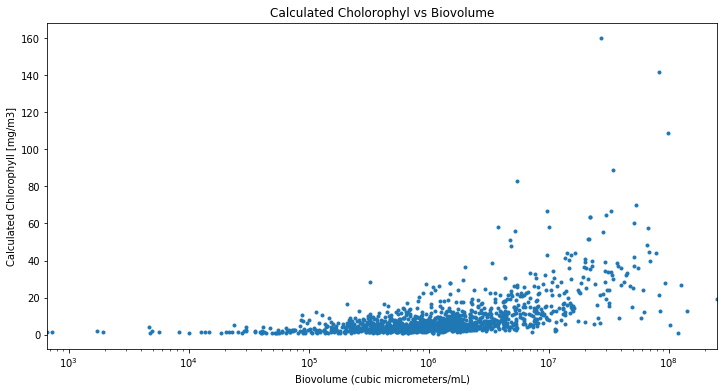

In [29]:
chlor_df = wq_df[(wq_df['Calculated Chlorophyll'].notnull()) & 
                (wq_df['Biovolume'].notnull())
               ]
ax = chlor_df.plot(y='Calculated Chlorophyll', x='Biovolume', 
                  figsize=(12,6), linestyle='none', marker='.', 
                  logx=True, legend=False)

ylabel='Calculated Chlorophyll' + ' ' + wq_units['Calculated Chlorophyll']
ax.set_ylabel(ylabel)

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

plt.title('Calculated Cholorophyl vs Biovolume') 

plt.show()


In [30]:
data1 = chlor_df['Biovolume']
data2 = chlor_df['Calculated Chlorophyll']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[1.81824116e+14 7.57515452e+07]
 [7.57515452e+07 1.36247317e+02]]

Pearsons correlation: 0.481

Spearmans correlation: 0.607


There is a positive correlation between Biovolume and Chlorophyll.

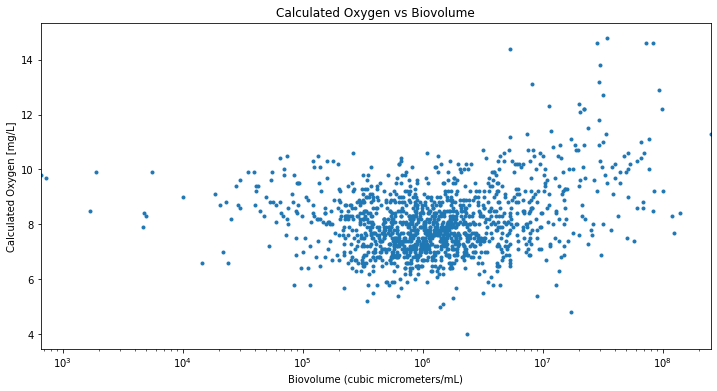

In [31]:
o2b_df = wq_df[(wq_df['Biovolume'].notnull()) & 
                (wq_df['Calculated Oxygen'].notnull())
               ]

ax = o2b_df.plot(y='Calculated Oxygen', x='Biovolume', 
                figsize=(12,6), linestyle='none', marker='.', 
                legend=False, logx=True, )

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

ylabel='Calculated Oxygen' + ' ' + wq_units['Calculated Oxygen']
ax.set_ylabel(ylabel)

plt.title('Calculated Oxygen vs Biovolume') 

plt.show()


In [32]:
data1 = o2b_df['Biovolume']
data2 = o2b_df['Calculated Oxygen']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[1.92898412e+14 5.76929737e+06]
 [5.76929737e+06 1.55496008e+00]]

Pearsons correlation: 0.333

Spearmans correlation: 0.161


There is a weak positive correlation between Biovolume and Oxygen.

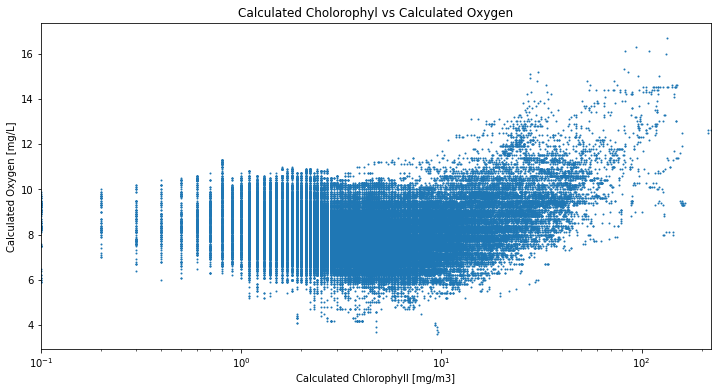

In [67]:
o2chlor_df = wq_df[(wq_df['Calculated Chlorophyll'].notnull()) & 
                (wq_df['Calculated Oxygen'].notnull())
               ]

ax = o2chlor_df.plot(y='Calculated Oxygen', x='Calculated Chlorophyll', 
                figsize=(12,6), linestyle='none', marker='.', 
                legend=False, logx=True )
ax.get_lines()[0].set_markersize('2')


xlabel='Calculated Chlorophyll' + ' ' + wq_units['Calculated Chlorophyll']
ax.set_xlabel(xlabel)

ylabel='Calculated Oxygen' + ' ' + wq_units['Calculated Oxygen']
ax.set_ylabel(ylabel)

plt.title('Calculated Cholorophyl vs Calculated Oxygen') 

plt.show()


In [34]:
data1 = o2chlor_df['Calculated Chlorophyll']
data2 = o2chlor_df['Calculated Oxygen']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[53.26027301  2.13119576]
 [ 2.13119576  1.03124445]]

Pearsons correlation: 0.288

Spearmans correlation: -0.101


Pearson says "weak positive" correlation between Chlorophyll and Oxygen. (I expected this to be larger).

Spearman says weak negative correlation.

Apparently, this is OK.

<blockquote>
    The pearson correlation detects [that] there is a general upwards motion in the combined data ... The spearman correlation just sees the ranks...
    
[ref](https://stats.stackexchange.com/questions/219029/what-is-the-explanation-for-having-a-pearsons-correlation-coefficient-significa/)
</blockquote>

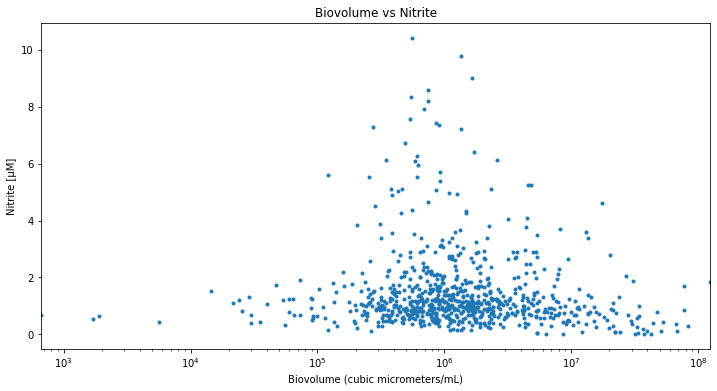

In [35]:
nutr1_df = wq_df[(wq_df['Biovolume'].notnull()) & 
                (wq_df['Nitrite'].notnull())
               ]
ax = nutr1_df.plot(x='Biovolume', y='Nitrite', figsize=(12,6),
            linestyle='none', marker='.', legend=False, logx=True, )

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

ylabel='Nitrite' + ' ' + wq_units['Nitrite']
ax.set_ylabel(ylabel)

plt.title('Biovolume vs Nitrite') 

plt.show()


In [36]:
data1 = nutr1_df['Biovolume']
data2 = nutr1_df['Nitrite']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[ 9.44719523e+13 -1.65577099e+06]
 [-1.65577099e+06  1.90002714e+00]]

Pearsons correlation: -0.124

Spearmans correlation: -0.112


There is a weak negative correlation between Biovolume and Nitrite.


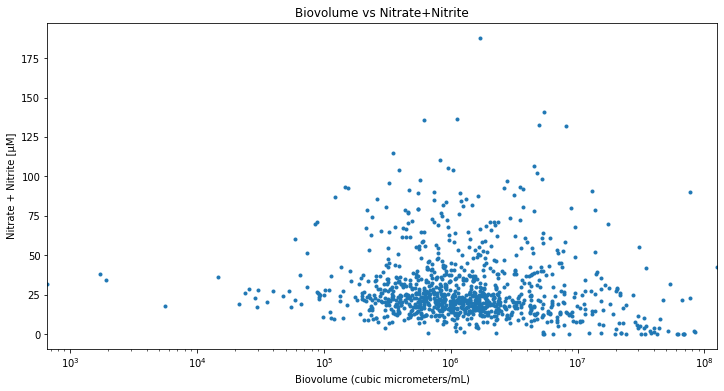

In [37]:
nutr2_df = wq_df[(wq_df['Biovolume'].notnull()) & 
                (wq_df['Nitrate + Nitrite'].notnull())
               ]
ax = nutr2_df.plot(x='Biovolume', y='Nitrate + Nitrite', figsize=(12,6),
            linestyle='none', marker='.', legend=False, logx=True, )

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

ylabel='Nitrate + Nitrite' + ' ' + wq_units['Nitrate + Nitrite']
ax.set_ylabel(ylabel)

plt.title('Biovolume vs Nitrate+Nitrite') 
plt.show()


In [38]:
data1 = nutr2_df['Biovolume']
data2 = nutr2_df['Nitrate + Nitrite']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[ 1.00442994e+14 -2.76845526e+07]
 [-2.76845526e+07  4.71172340e+02]]

Pearsons correlation: -0.127

Spearmans correlation: -0.175


There is a weak negative correlation between Biovolume and Nitrate + Nitrite.


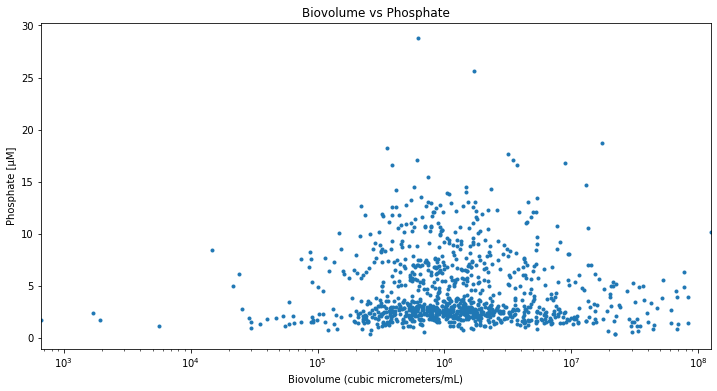

In [39]:
nutr3_df = wq_df[(wq_df['Biovolume'].notnull()) & 
                (wq_df['Phosphate'].notnull())
               ]
ax = nutr3_df.plot(x='Biovolume', y='Phosphate', figsize=(12,6),
            linestyle='none', marker='.', legend=False, logx=True, )

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

ylabel='Phosphate' + ' ' + wq_units['Phosphate']
ax.set_ylabel(ylabel)

plt.title('Biovolume vs Phosphate') 

plt.show()


In [40]:
data1 = nutr3_df['Biovolume']
data2 = nutr3_df['Phosphate']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[ 1.00442994e+14 -2.12971673e+06]
 [-2.12971673e+06  1.18350982e+01]]

Pearsons correlation: -0.062

Spearmans correlation: -0.042


There is a weak negative correlation between Biovolume and Phosphate.


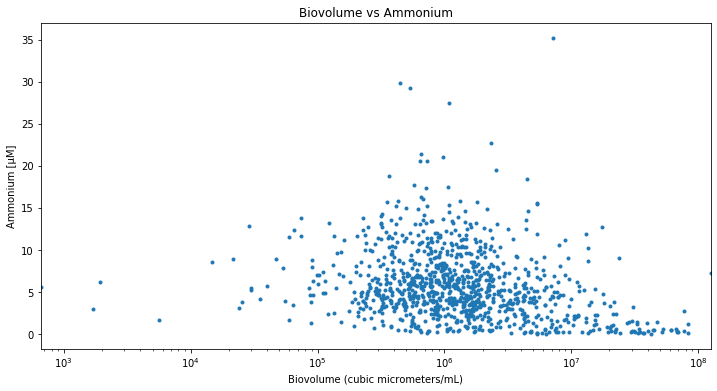

In [41]:
nutr4_df = wq_df[(wq_df['Biovolume'].notnull()) & 
                (wq_df['Ammonium'].notnull())
               ]
ax = nutr4_df.plot(x='Biovolume', y='Ammonium', figsize=(12,6),
            linestyle='none', marker='.', legend=False, logx=True, )

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

ylabel='Ammonium' + ' ' + wq_units['Ammonium']
ax.set_ylabel(ylabel)

plt.title('Biovolume vs Ammonium') 

plt.show()


In [42]:
data1 = nutr4_df['Biovolume']
data2 = nutr4_df['Ammonium']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[ 1.00882353e+14 -1.04422690e+07]
 [-1.04422690e+07  1.73662130e+01]]

Pearsons correlation: -0.249

Spearmans correlation: -0.298


There is a weak negative correlation between Biovolume and Ammonium.

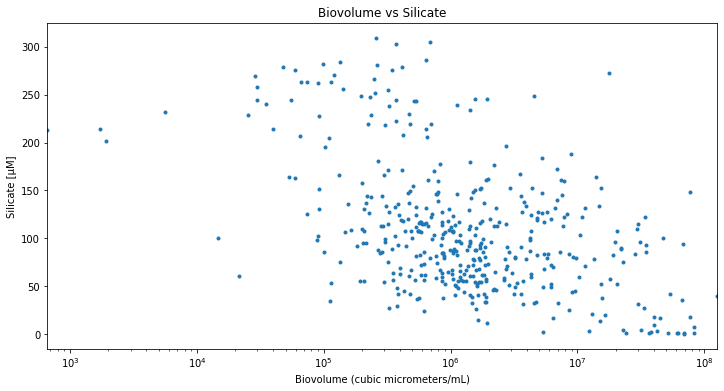

In [43]:
nutr5_df = wq_df[(wq_df['Biovolume'].notnull()) & 
                (wq_df['Silicate'].notnull())
               ]
ax = nutr5_df.plot(x='Biovolume', y='Silicate', figsize=(12,6),
            linestyle='none', marker='.', legend=False, logx=True, )

xlabel='Biovolume' + ' ' + wq_units['Biovolume']
ax.set_xlabel(xlabel)

ylabel='Silicate' + ' ' + wq_units['Silicate']
ax.set_ylabel(ylabel)

plt.title('Biovolume vs Silicate') 

plt.show()


In [44]:
data1 = nutr5_df['Biovolume']
data2 = nutr5_df['Silicate']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[ 2.05952317e+14 -2.96703951e+08]
 [-2.96703951e+08  4.51862307e+03]]

Pearsons correlation: -0.308

Spearmans correlation: -0.436


There is a weak negative correlation between Biovolume and Silicate.


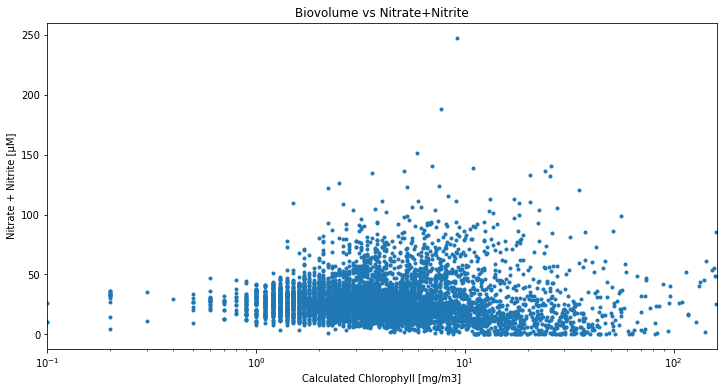

In [69]:
nutr6_df = wq_df[(wq_df['Calculated Chlorophyll'].notnull()) & 
                (wq_df['Nitrate + Nitrite'].notnull())
               ]
ax = nutr6_df.plot(x='Calculated Chlorophyll', y='Nitrate + Nitrite', figsize=(12,6),
            linestyle='none', marker='.', legend=False, logx=True, )

xlabel='Calculated Chlorophyll' + ' ' + wq_units['Calculated Chlorophyll']
ax.set_xlabel(xlabel)

ylabel='Nitrate + Nitrite' + ' ' + wq_units['Nitrate + Nitrite']
ax.set_ylabel(ylabel)

plt.title('Biovolume vs Nitrate+Nitrite') 
plt.show()


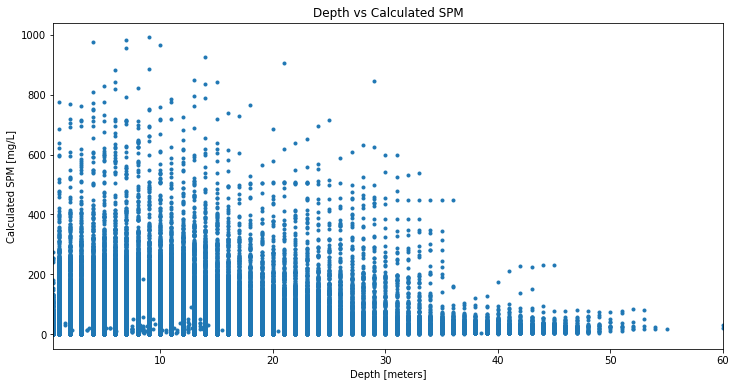

In [45]:
spm_df = wq_df[(wq_df['Depth'].notnull()) & 
                (wq_df['Calculated SPM'].notnull())
               ]
ax = spm_df.plot(x='Depth', y='Calculated SPM', figsize=(12,6),
            linestyle='none', marker='.', legend=False)

xlabel='Depth' + ' ' + wq_units['Depth']
ax.set_xlabel(xlabel)

ylabel='Calculated SPM' + ' ' + wq_units['Calculated SPM']
ax.set_ylabel(ylabel)

plt.title('Depth vs Calculated SPM') 

plt.show()


In [46]:
data1 = spm_df['Depth']
data2 = spm_df['Calculated SPM']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[  52.12704435   18.83173231]
 [  18.83173231 2438.70013001]]

Pearsons correlation: 0.053

Spearmans correlation: 0.074


There is essentially no correlation between depth and suspended particulate matter.

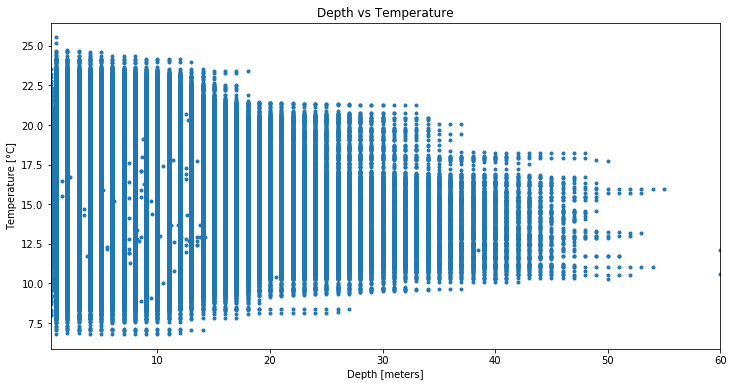

In [47]:
temp_df = wq_df[(wq_df['Depth'].notnull()) & 
                (wq_df['Temperature'].notnull())
               ]
ax = spm_df.plot(x='Depth', y='Temperature', figsize=(12,6),
            linestyle='none', marker='.', legend=False)

xlabel='Depth' + ' ' + wq_units['Depth']
ax.set_xlabel(xlabel)

ylabel='Temperature' + ' ' + wq_units['Temperature']
ax.set_ylabel(ylabel)

plt.title('Depth vs Temperature') 

plt.show()


In [48]:
data1 = temp_df['Depth']
data2 = temp_df['Temperature']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[50.29891469 -3.27247875]
 [-3.27247875 11.9102004 ]]

Pearsons correlation: -0.134

Spearmans correlation: -0.114


There is a weak negative correlation between depth and temperature. (I expected this to be larger).

<hr style="border: 3px solid green;">

Sigma-t is a measure of the density of the water, which is calculated as a function of salinity and temperature. Density increases with increasing salinity and decreasing temperature,

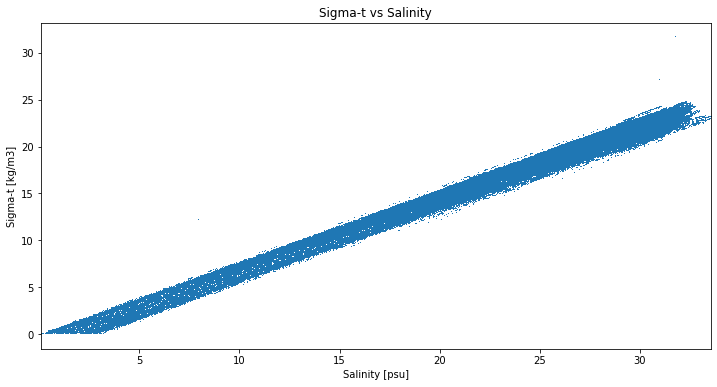

In [63]:
sal_df = wq_df[(wq_df['Sigma-t'].notnull()) & 
                (wq_df['Salinity'].notnull())
               ]
ax = sal_df.plot(x='Salinity',y='Sigma-t',  figsize=(12,6),
            linestyle='none', marker=',', legend=False)

xlabel='Salinity' + ' ' + wq_units['Salinity']
ax.set_xlabel(xlabel)

ylabel='Sigma-t' + ' ' + wq_units['Sigma-t']
ax.set_ylabel(ylabel)

plt.title('Sigma-t vs Salinity') 

plt.show()


In [50]:
data1 = sal_df['Sigma-t']
data2 = sal_df['Salinity']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[35.07370765 45.52421163]
 [45.52421163 59.89455839]]

Pearsons correlation: 0.993

Spearmans correlation: 0.978


There is a very clear correlation between Signma-t and salinity.

What about Temperature?

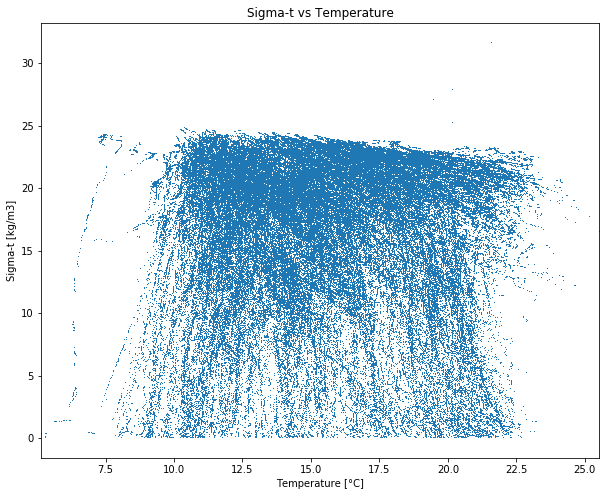

In [51]:
temp_df = wq_df[(wq_df['Sigma-t'].notnull()) & 
                (wq_df['Temperature'].notnull())
               ]
ax = temp_df.plot(x='Temperature', y='Sigma-t',figsize=(10,8),
            linestyle='none', marker=',', legend=False)

xlabel='Temperature' + ' ' + wq_units['Temperature']
ax.set_xlabel(xlabel)

ylabel='Sigma-t' + ' ' + wq_units['Sigma-t']
ax.set_ylabel(ylabel)

plt.title('Sigma-t vs Temperature') 

plt.show()


In [52]:
data1 = temp_df['Sigma-t']
data2 = temp_df['Temperature']

covariance = np.cov(data1, data2)
print("Covariance matrix:\n", covariance)
print("")
corr, _ = stats.pearsonr(data1, data2)
print('Pearsons correlation: %.3f' % corr)
print("")
corr2, _ = stats.spearmanr(data1, data2)
print('Spearmans correlation: %.3f' % corr2)

Covariance matrix:
 [[35.07730818 -0.66416418]
 [-0.66416418 11.20725859]]

Pearsons correlation: -0.033

Spearmans correlation: -0.049


Perhaps the effect of the salinity is greater than the effect of the temperature?

What if we stick to a group of stations with similar salinity and plot both temperature and salinity on the same plot?

In [53]:
from matplotlib.lines import Line2D
def plot_me(group_number, marker):
    """
    Plot Salinity and Temperature vs Sigma-t for the given station group.
    """
    group_df = st_groups[group_number][(st_groups[group_number]['Sigma-t'].notnull()) & 
                       (st_groups[group_number]['Temperature'].notnull()) &
                       (st_groups[group_number]['Salinity'].notnull())
                      ]

    fig, ax1 = plt.subplots(figsize=(12,8))
    ax2 = ax1.twinx()

    group_df.plot(x='Sigma-t',y='Salinity', ax=ax1, color='orange',
             linestyle='none', marker=marker)

    group_df.plot(x='Sigma-t',y='Temperature', ax=ax2,
            linestyle='none', marker=marker)

    xlabel='Sigma-t' + ' ' + wq_units['Sigma-t']
    ax1.set_xlabel(xlabel)

    ylabel1='Salinity' + ' ' + wq_units['Salinity']
    ax1.set_ylabel(ylabel1)
    custom_leg1 = [Line2D([0], [0], marker='o', color='orange')]
    ax1.legend(custom_leg1, ['Salnity'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left")

    ylabel2='Temperature' + ' ' + wq_units['Temperature']
    ax2.set_ylabel(ylabel2)
    custom_leg2 = [Line2D([0], [0], marker='o', color='blue')]
    ax2.legend(custom_leg2, ['Temperature'], bbox_to_anchor=(0.82,1.02,0,0), loc="lower left")
    
    title = "Sigma-t vs Salinity and Temperature\nStation Group " + str(group_number)
    title = title + " " + st_group_names[group_number]

    plt.title(title)

    plt.show()
#end_def

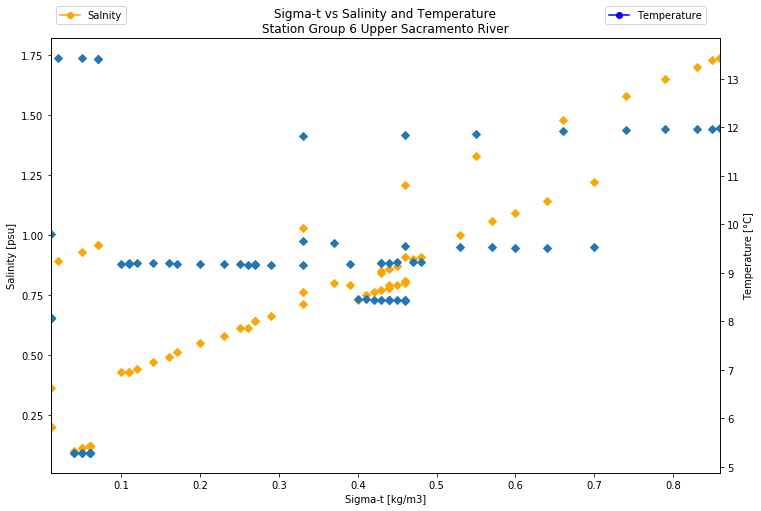

In [54]:
plot_me(6, 'D')

The correlation between salinity and Sigma-t is clear, even in the Sacramento River.

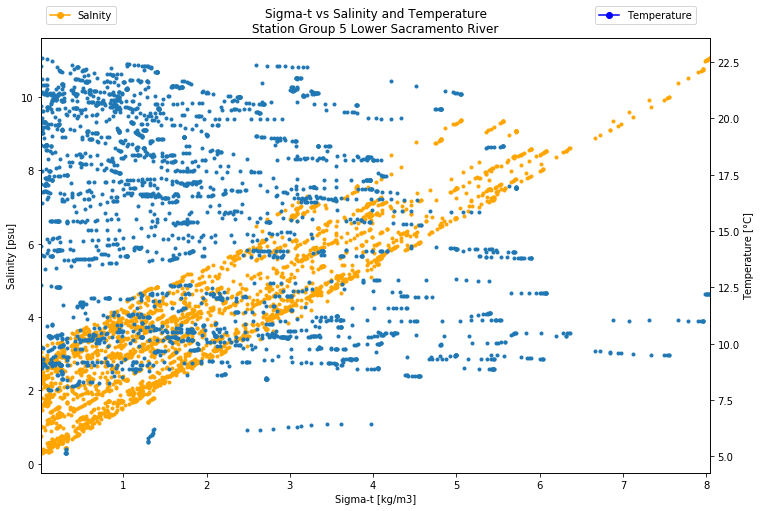

In [55]:
plot_me(5, '.')

As salinity increases, the . marker becomes too large.

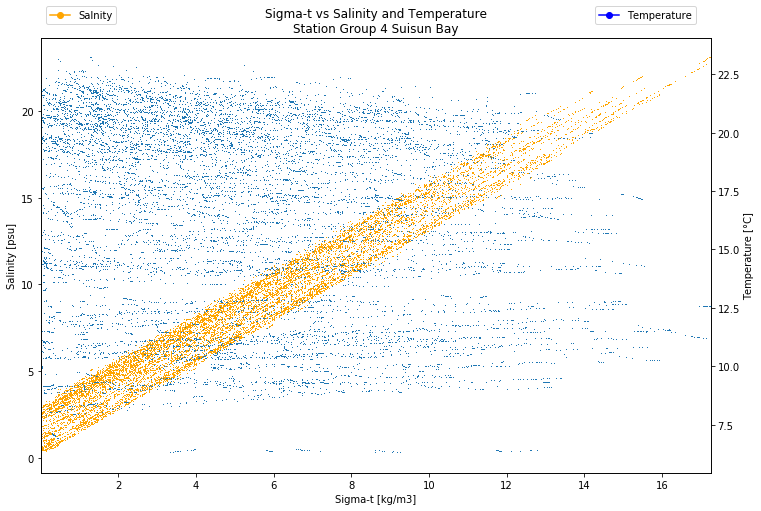

In [62]:
plot_me(4, ',')

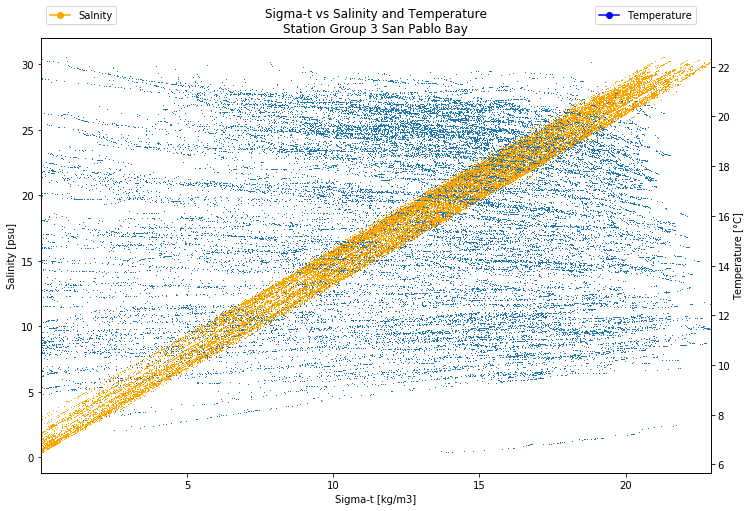

In [57]:
plot_me(3, ',')

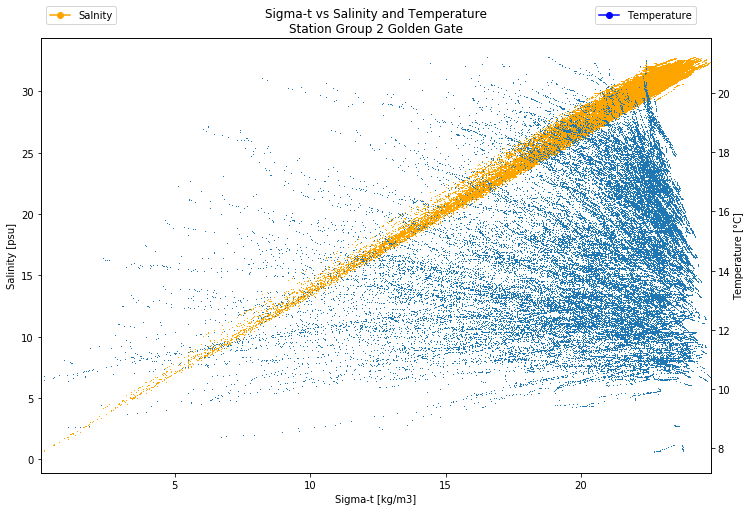

In [58]:
plot_me(2, ',')

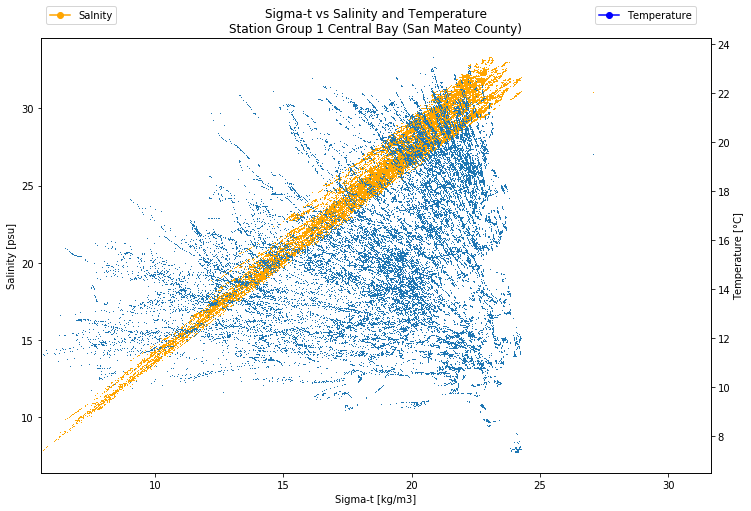

In [59]:
plot_me(1, ',')


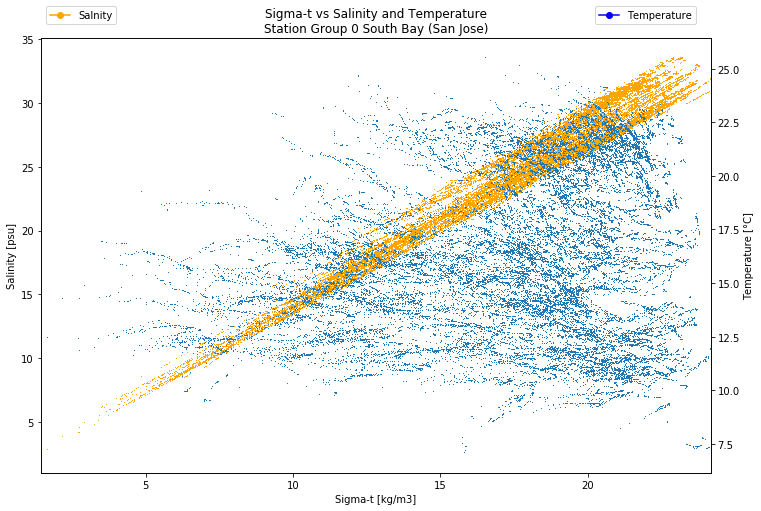

In [60]:
plot_me(0, ',')